## Dependecies

In [1]:
# Image 
import cv2
from sklearn.preprocessing import normalize
from albumentations import Compose, ShiftScaleRotate, RandomGamma

# Machine Learning
import keras
from keras.layers import *
from keras.optimizers import SGD
from keras.models import load_model, Model
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard

from keras import backend as K

# Helper libraries
import os
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report

Using TensorFlow backend.


## Define Hyperparameters

In [2]:
SHAPE      = (256, 256, 1) # target image shape
BATCH_SIZE = 24   # training batch size
N_SPLITS   = 3    # k-fold splits
EPOCHS     = 100  # training epochs
SEED       = 1881 # Used for reproduction

DIR             = 'data/OCT2017/' # DATA Location Directory
MODEL_SAVE_PATH = "models/"       # K-Fold Model Path
LOGS_PATH       = "logs/"         # Tensorboard Records Path

In [3]:
os.listdir(DIR)

['test', 'train']

## Data Generator

In [4]:
class OCT_TrainingDataGenerator:
    
    """
    input_shape --> TUPLE.wanted image size
    batch_size  --> INT.yielding data size for every iteration
    orders      --> LIST.which images will be used. max=len(all_images). it can be used for K-fold(CV).
    DIR         --> STR.DIR directory must consists "test", "train" dirs.
    augment     --> BOOL. 
    """
    
    def __init__(self, input_shape, batch_size, orders, DIR, augment=True):
        self.SHAPE       = input_shape
        self.BATCH_SIZE  = batch_size
        self.arr         = orders
        self.aug         = augment
        
        self.DIR         = DIR
        self.SUBDIRS     = ['train']
        self.SUB_SUBDIRS = ['CNV', "DME", "DRUSEN", "NORMAL"] 
    
    def __len__(self):
        return len(self.get_img_paths())
    
    def get_img_paths(self):
        # Get all training image paths.
        arr = []
        for x in self.SUBDIRS:
            for y in self.SUB_SUBDIRS:
                for im in os.listdir(os.path.join(self.DIR,x,y)):
                    if ".jpeg" in im:
                        arr.append(os.path.join(self.DIR,x,y,im))
        return arr

    def get_img(self, img_path):
        img = cv2.imread(img_path)
        return np.array(img)
    
    def augmenting(self, img):
        if self.aug:
            augment = Compose([ShiftScaleRotate(p=0.5, shift_limit=0.01, scale_limit=0., rotate_limit=10),
                               RandomGamma(p=0.4)])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    def resize_and_normalize(self, img):
        img = cv2.resize(img, SHAPE[:2])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # OpenCV loads image as BGR, now we should convert it to grayscale.
        img = normalize(img) # normalize the image in 0-1 range for faster training.
        return np.expand_dims(img, axis=2)
    
    def data_generator(self):
        img_paths = np.array(self.get_img_paths())
        np.random.shuffle(img_paths)
        
        while True:
            x = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float16)
            y = np.empty((self.BATCH_SIZE, 4), dtype=np.float16)
            
            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                # x
                img_path = img_paths[id_]
                img = self.get_img(img_path)
                augmented_img = self.augmenting(img)
                img = self.resize_and_normalize(augmented_img)
                  
                # y 
                if 'CNV' in img_path:
                    label = [1,0,0,0]
                elif 'DME' in img_path:
                    label = [0,1,0,0]
                elif 'DRUSEN' in img_path:
                    label = [0,0,1,0]
                elif 'NORMAL' in img_path:
                    label = [0,0,0,1]
                    
                # Store the values    
                x[ix] = img
                y[ix] = label

            yield x,y

In [5]:
# Testing data generator library
dataset = OCT_TrainingDataGenerator(SHAPE, 1, len(range(10)), DIR=DIR, augment=True)

for ix, data in enumerate(dataset.data_generator()):
    x, y = data
    print(x)
    print(x.shape)
    print(y)
    print(y.shape)
    
    if ix==0:
        break

[[[[0.03937]
   [0.0535 ]
   [0.03027]
   ...
   [0.0444 ]
   [0.05048]
   [0.03937]]

  [[0.04205]
   [0.0497 ]
   [0.0392 ]
   ...
   [0.04398]
   [0.0373 ]
   [0.0411 ]]

  [[0.0358 ]
   [0.0358 ]
   [0.02132]
   ...
   [0.04092]
   [0.03494]
   [0.03069]]

  ...

  [[0.01924]
   [0.03848]
   [0.03574]
   ...
   [0.04947]
   [0.0577 ]
   [0.066  ]]

  [[0.03815]
   [0.04086]
   [0.05176]
   ...
   [0.04086]
   [0.04904]
   [0.0627 ]]

  [[0.03806]
   [0.03806]
   [0.04892]
   ...
   [0.06525]
   [0.0625 ]
   [0.06525]]]]
(1, 256, 256, 1)
[[0. 0. 0. 1.]]
(1, 4)


## Metrics

In [6]:
# credit: https://stackoverflow.com/a/45305384

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

## Learning Rate Scheduler

In [7]:
# credit: https://gist.github.com/jeremyjordan/5a222e04bb78c242f5763ad40626c452

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

## Creating Model

In [8]:
# credit: https://github.com/titu1994/keras-squeeze-excite-network/blob/master/se.py

def squeeze_excite_block(input, ratio=16):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [9]:
def create_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = squeeze_excite_block(x)
    x = Conv2D(64, (5, 5), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = squeeze_excite_block(x)
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = squeeze_excite_block(x)
    x = Conv2D(128, (2, 2), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = squeeze_excite_block(x)
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    concat = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(concat)
    
    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(4, activation='softmax')(x)
    
    model = Model(init, x)
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-3, momentum=0.9), metrics=['acc', precision, recall, f1])
    return model

In [10]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

## Train the model

In [11]:
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

dataset = OCT_TrainingDataGenerator(SHAPE, BATCH_SIZE, 0, DIR, augment=False)

for ix, (train_index, test_index) in enumerate(kf.split(range(len(dataset)))):
    print("** FOLD {} **".format(ix))       
    
    tg = OCT_TrainingDataGenerator(SHAPE, BATCH_SIZE, train_index, DIR, augment=True)  # Create training data generator with augmentation is true.
    vg = OCT_TrainingDataGenerator(SHAPE, BATCH_SIZE, test_index , DIR, augment=False) # Create validation data generator with augmentation is false.
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.8,
                             cycle_length=10,
                             mult_factor=1.)

    model_ckpt = os.path.join(MODEL_SAVE_PATH,"heysaw_fold_"+str(ix)+".h5")
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir=os.path.join(LOGS_PATH,'log_'+str(ix)), update_freq='epoch'), schedule] 
                                               
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(test_index)//BATCH_SIZE,
                        callbacks=callbacks)


** FOLD 0 **
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 2272s - loss: 0.8589 - acc: 0.6729 - precision: 0.7497 - recall: 0.5764 - f1: 0.6474 - val_loss: 0.8763 - val_acc: 0.6560 - val_precision: 0.7124 - val_recall: 0.6071 - val_f1: 0.6544

Epoch 00001: val_loss improved from inf to 0.87630, saving model to models/heysaw_fold_0.h5
Epoch 2/100
 - 1749s - loss: 0.5728 - acc: 0.7893 - precision: 0.8299 - recall: 0.7428 - f1: 0.7829 - val_loss: 3.1529 - val_acc: 0.5621 - val_precision: 0.5623 - val_recall: 0.5618 - val_f1: 0.5620

Epoch 00002: val_loss did not improve from 0.87630
Epoch 3/100
 - 1736s - loss: 0.4445 - acc: 0.8380 - precision: 0.8612 - recall: 0.8118 - f1: 0.8352 - val_loss: 0.9460 - val_acc: 0.7998 - val_precision: 0.8093 - val_recall: 0.7952 - val_f1: 0.8020

Epoch 00003: val_loss did not improve from 0.87630
Epoch 4/100
 - 1379s - loss: 0.3825 - acc: 0.8610 - precision: 0.8780 - recall: 0.8430 - f1: 0.8598 - val_loss: 0.3696 - val_acc: 0.8674 - val_pr


Epoch 00062: val_loss improved from 0.07867 to 0.07555, saving model to models/heysaw_fold_0.h5
Epoch 63/100
 - 1603s - loss: 0.0715 - acc: 0.9749 - precision: 0.9758 - recall: 0.9741 - f1: 0.9750 - val_loss: 0.0695 - val_acc: 0.9761 - val_precision: 0.9769 - val_recall: 0.9754 - val_f1: 0.9761

Epoch 00063: val_loss improved from 0.07555 to 0.06947, saving model to models/heysaw_fold_0.h5
Epoch 64/100
 - 1509s - loss: 0.0722 - acc: 0.9742 - precision: 0.9749 - recall: 0.9734 - f1: 0.9742 - val_loss: 0.1157 - val_acc: 0.9639 - val_precision: 0.9646 - val_recall: 0.9632 - val_f1: 0.9639

Epoch 00064: val_loss did not improve from 0.06947
Epoch 65/100
 - 1448s - loss: 0.0758 - acc: 0.9731 - precision: 0.9738 - recall: 0.9725 - f1: 0.9731 - val_loss: 0.0803 - val_acc: 0.9729 - val_precision: 0.9733 - val_recall: 0.9725 - val_f1: 0.9729

Epoch 00065: val_loss did not improve from 0.06947
Epoch 66/100
 - 1337s - loss: 0.0730 - acc: 0.9745 - precision: 0.9751 - recall: 0.9738 - f1: 0.9745 -


Epoch 00094: val_loss did not improve from 0.04996
Epoch 95/100
 - 1589s - loss: 0.0556 - acc: 0.9804 - precision: 0.9809 - recall: 0.9799 - f1: 0.9804 - val_loss: 0.0487 - val_acc: 0.9844 - val_precision: 0.9846 - val_recall: 0.9843 - val_f1: 0.9844

Epoch 00095: val_loss improved from 0.04996 to 0.04866, saving model to models/heysaw_fold_0.h5
Epoch 96/100
 - 1413s - loss: 0.0553 - acc: 0.9808 - precision: 0.9813 - recall: 0.9803 - f1: 0.9808 - val_loss: 0.1336 - val_acc: 0.9574 - val_precision: 0.9582 - val_recall: 0.9561 - val_f1: 0.9571

Epoch 00096: val_loss did not improve from 0.04866
Epoch 97/100
 - 1319s - loss: 0.0542 - acc: 0.9805 - precision: 0.9810 - recall: 0.9800 - f1: 0.9805 - val_loss: 0.0722 - val_acc: 0.9754 - val_precision: 0.9757 - val_recall: 0.9752 - val_f1: 0.9754

Epoch 00097: val_loss did not improve from 0.04866
Epoch 98/100
 - 1593s - loss: 0.0555 - acc: 0.9806 - precision: 0.9810 - recall: 0.9801 - f1: 0.9805 - val_loss: 0.0656 - val_acc: 0.9785 - val_pre


Epoch 00026: val_loss did not improve from 0.06807
Epoch 27/100
 - 1441s - loss: 0.0641 - acc: 0.9776 - precision: 0.9780 - recall: 0.9769 - f1: 0.9775 - val_loss: 0.0645 - val_acc: 0.9787 - val_precision: 0.9790 - val_recall: 0.9783 - val_f1: 0.9787

Epoch 00027: val_loss improved from 0.06807 to 0.06451, saving model to models/heysaw_fold_1.h5
Epoch 28/100
 - 1543s - loss: 0.0629 - acc: 0.9769 - precision: 0.9774 - recall: 0.9764 - f1: 0.9769 - val_loss: 0.0921 - val_acc: 0.9681 - val_precision: 0.9691 - val_recall: 0.9670 - val_f1: 0.9680

Epoch 00028: val_loss did not improve from 0.06451
Epoch 29/100
 - 1441s - loss: 0.0643 - acc: 0.9772 - precision: 0.9778 - recall: 0.9765 - f1: 0.9772 - val_loss: 0.0694 - val_acc: 0.9742 - val_precision: 0.9755 - val_recall: 0.9739 - val_f1: 0.9747

Epoch 00029: val_loss did not improve from 0.06451
Epoch 30/100
 - 1469s - loss: 0.0620 - acc: 0.9778 - precision: 0.9783 - recall: 0.9775 - f1: 0.9779 - val_loss: 0.0620 - val_acc: 0.9781 - val_pre


Epoch 00058: val_loss did not improve from 0.03924
Epoch 59/100
 - 1321s - loss: 0.0410 - acc: 0.9859 - precision: 0.9861 - recall: 0.9856 - f1: 0.9858 - val_loss: 0.0348 - val_acc: 0.9885 - val_precision: 0.9886 - val_recall: 0.9884 - val_f1: 0.9885

Epoch 00059: val_loss improved from 0.03924 to 0.03478, saving model to models/heysaw_fold_1.h5
Epoch 60/100
 - 1363s - loss: 0.0427 - acc: 0.9851 - precision: 0.9855 - recall: 0.9849 - f1: 0.9852 - val_loss: 0.0400 - val_acc: 0.9877 - val_precision: 0.9880 - val_recall: 0.9876 - val_f1: 0.9878

Epoch 00060: val_loss did not improve from 0.03478
Epoch 61/100
 - 1377s - loss: 0.0400 - acc: 0.9860 - precision: 0.9863 - recall: 0.9858 - f1: 0.9861 - val_loss: 0.0573 - val_acc: 0.9819 - val_precision: 0.9822 - val_recall: 0.9818 - val_f1: 0.9820

Epoch 00061: val_loss did not improve from 0.03478
Epoch 62/100
 - 1422s - loss: 0.0388 - acc: 0.9867 - precision: 0.9869 - recall: 0.9864 - f1: 0.9867 - val_loss: 0.1322 - val_acc: 0.9503 - val_pre


Epoch 00090: val_loss did not improve from 0.03171
Epoch 91/100
 - 1368s - loss: 0.0310 - acc: 0.9892 - precision: 0.9894 - recall: 0.9890 - f1: 0.9892 - val_loss: 0.0268 - val_acc: 0.9920 - val_precision: 0.9921 - val_recall: 0.9919 - val_f1: 0.9920

Epoch 00091: val_loss improved from 0.03171 to 0.02679, saving model to models/heysaw_fold_1.h5
Epoch 92/100
 - 1363s - loss: 0.0326 - acc: 0.9884 - precision: 0.9886 - recall: 0.9882 - f1: 0.9884 - val_loss: 0.0416 - val_acc: 0.9877 - val_precision: 0.9878 - val_recall: 0.9875 - val_f1: 0.9876

Epoch 00092: val_loss did not improve from 0.02679
Epoch 93/100
 - 1401s - loss: 0.0306 - acc: 0.9894 - precision: 0.9895 - recall: 0.9893 - f1: 0.9894 - val_loss: 0.0322 - val_acc: 0.9894 - val_precision: 0.9896 - val_recall: 0.9890 - val_f1: 0.9893

Epoch 00093: val_loss did not improve from 0.02679
Epoch 94/100
 - 1376s - loss: 0.0308 - acc: 0.9891 - precision: 0.9893 - recall: 0.9889 - f1: 0.9891 - val_loss: 0.0336 - val_acc: 0.9892 - val_pre


Epoch 00053: val_loss did not improve from 0.02464
Epoch 54/100
 - 1218s - loss: 0.0314 - acc: 0.9892 - precision: 0.9894 - recall: 0.9891 - f1: 0.9892 - val_loss: 0.0344 - val_acc: 0.9875 - val_precision: 0.9879 - val_recall: 0.9873 - val_f1: 0.9876

Epoch 00054: val_loss did not improve from 0.02464
Epoch 55/100
 - 1331s - loss: 0.0310 - acc: 0.9894 - precision: 0.9895 - recall: 0.9892 - f1: 0.9894 - val_loss: 0.0358 - val_acc: 0.9881 - val_precision: 0.9882 - val_recall: 0.9879 - val_f1: 0.9880

Epoch 00055: val_loss did not improve from 0.02464
Epoch 56/100
 - 1314s - loss: 0.0296 - acc: 0.9895 - precision: 0.9897 - recall: 0.9893 - f1: 0.9895 - val_loss: 0.0262 - val_acc: 0.9917 - val_precision: 0.9917 - val_recall: 0.9916 - val_f1: 0.9916

Epoch 00056: val_loss did not improve from 0.02464
Epoch 57/100
 - 1297s - loss: 0.0284 - acc: 0.9899 - precision: 0.9901 - recall: 0.9897 - f1: 0.9899 - val_loss: 0.0224 - val_acc: 0.9928 - val_precision: 0.9928 - val_recall: 0.9926 - val_f1:


Epoch 00085: val_loss did not improve from 0.02074
Epoch 86/100
 - 1315s - loss: 0.0238 - acc: 0.9913 - precision: 0.9914 - recall: 0.9911 - f1: 0.9912 - val_loss: 0.0225 - val_acc: 0.9930 - val_precision: 0.9930 - val_recall: 0.9928 - val_f1: 0.9929

Epoch 00086: val_loss did not improve from 0.02074
Epoch 87/100
 - 1319s - loss: 0.0232 - acc: 0.9919 - precision: 0.9921 - recall: 0.9918 - f1: 0.9919 - val_loss: 0.0223 - val_acc: 0.9928 - val_precision: 0.9928 - val_recall: 0.9928 - val_f1: 0.9928

Epoch 00087: val_loss did not improve from 0.02074
Epoch 88/100
 - 1336s - loss: 0.0240 - acc: 0.9914 - precision: 0.9915 - recall: 0.9913 - f1: 0.9914 - val_loss: 0.0290 - val_acc: 0.9909 - val_precision: 0.9910 - val_recall: 0.9909 - val_f1: 0.9909

Epoch 00088: val_loss did not improve from 0.02074
Epoch 89/100
 - 1342s - loss: 0.0251 - acc: 0.9911 - precision: 0.9913 - recall: 0.9910 - f1: 0.9911 - val_loss: 0.0236 - val_acc: 0.9923 - val_precision: 0.9924 - val_recall: 0.9923 - val_f1:

## Testing the model

In [12]:
def get_test_data():
    # Load test images' paths.
    arr = []
    for dir_ in ['test/']:
        for y in ['CNV', "DME", "DRUSEN", "NORMAL"]:
            for im in os.listdir(os.path.join(DIR,dir_,y)):
                arr.append(os.path.join(DIR,dir_,y,im))
    
    # Get and Store test images and labels.
    x = np.empty((len(arr),)+SHAPE, dtype=np.float16)
    y = np.empty((len(arr), 4), dtype=np.float16)
    
    for ix, path in tqdm(enumerate(arr)):
        img = np.array(cv2.imread(path))
        img = cv2.resize(img, SHAPE[:2])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = normalize(img)
        img = np.expand_dims(img, axis=2)

        if 'CNV' in path:
            label = [1,0,0,0]
        elif 'DME' in path:
            label = [0,1,0,0]
        elif 'DRUSEN' in path:
            label = [0,0,1,0]
        elif 'NORMAL' in path:
            label = [0,0,0,1]
            
        x[ix] = img
        y[ix] = label
        
    return x, y

In [13]:
x, y = get_test_data()

1000it [00:19, 54.17it/s]


In [14]:
# Threshold predictions
def threshold_arr(array):
    
    # Get all predictions from array
    # Find "max confident score location" in predictions
    # Create numpy zeros array
    # Just make "max confident score location" is 1 in numpy zeros array (other's zero)
    # Store thresholded prediction in new array
    
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float16))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float16)

## Load Best Model

In [15]:
# Load all models [3-fold(CV)]
models = []
scores = []
for i in range(3):
    print("** MODEL {} **".format(i))
    model = load_model(os.path.join(MODEL_SAVE_PATH,"heysaw_fold_"+str(i)+".h5"), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    score = model.evaluate(x, y, verbose=0)
    print(score)
    scores.append(score[0])
    models.append(model)

** MODEL 0 **
[0.05473858994769398, 0.98, 0.98, 0.979, 0.979492036819458]
** MODEL 1 **
[0.028088031499937643, 0.989, 0.989, 0.989, 0.9889999828338623]
** MODEL 2 **
[0.037993883370538245, 0.988, 0.988, 0.988, 0.987999984741211]


In [16]:
# Choose best scored model according to minimum loss
best_model_index = int(np.array(scores).argmin())
model = models[best_model_index]

## Visualize Results

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}'.format(accuracy))
    plt.savefig("stuffs/confusion_matrix.png", dpi=150)
    plt.show()

Accuracy: 0.989, F1_Score: 0.9890404823606509, Precision: 0.9892547782694662, Recall: 0.989


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       250
           1       1.00      0.98      0.99       250
           2       0.99      0.98      0.99       250
           3       1.00      1.00      1.00       250

   micro avg       0.99      0.99      0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000
 samples avg       0.99      0.99      0.99      1000





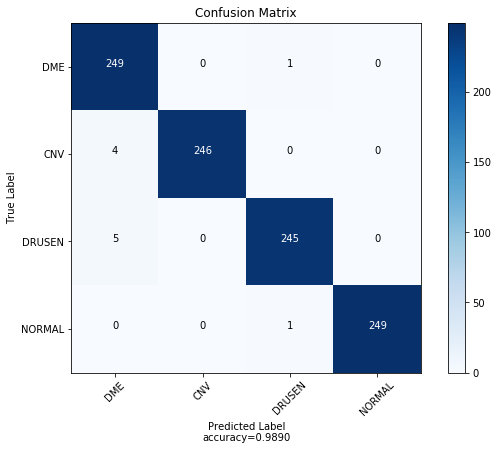

In [18]:
y_preds = threshold_arr(model.predict(x, verbose=0))

results = precision_recall_fscore_support(y, y_preds ,average='macro')
acc = accuracy_score(y, y_preds)

print("Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ['DME', 'CNV', 'DRUSEN', 'NORMAL'],
                      title        = "Confusion Matrix")

## Inference

In [19]:
for i in range(5): 
    img = np.array(cv2.imread(DIR+"test/NORMAL/NORMAL-2434258-1.jpeg"))
    img = cv2.resize(img, SHAPE[:2])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = normalize(img)
    img = np.expand_dims(img, axis=2)
    
    start = time.time()
    prediction = model.predict(np.expand_dims(img, axis=0), batch_size=1)
    finish = time.time()
    
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[0. 0. 0. 1.]]
373.9151954650879 ms
***
[[0. 0. 0. 1.]]
12.000799179077148 ms
***
[[0. 0. 0. 1.]]
11.966466903686523 ms
***
[[0. 0. 0. 1.]]
12.933969497680664 ms
***
[[0. 0. 0. 1.]]
11.968612670898438 ms
***
